In [1]:
import os
import torch
print("pytorch version {}".format(torch.__version__))

pytorch version 2.4.0+cu121


In [ ]:
if 'IS_GRADESCOPE_ENV' not in os.environ:
  !pip install torch==2.4.0

In [ ]:
# Install torch geometric
if 'IS_GRADESCOPE_ENV' not in os.environ:
  torch_version = str(torch.__version__)
  scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
  sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
  !pip install torch-scatter -f $scatter_src
  !pip install torch-sparse -f $sparse_src
  !pip install torch-geometric
  !pip install ogb

In [4]:
import torch
import torch_geometric
from torch_geometric.datasets import Planetoid
import numpy as np

In [5]:
dataset = Planetoid(root="/dataset", name="")

Processing...
Done!


In [6]:
data = dataset[0]
data

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])

In [7]:
src_nodes = data.edge_index[0]
dest_nodes = data.edge_index[1]

In [12]:
# To compute Node of degree 1
Degree = torch.bincount(src_nodes, minlength= len(data.x)).tolist()
set(Degree)
#node_degree_1 = (Degree == 1).nonzero(as_tuple=True)[0]

{1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 21,
 22,
 23,
 26,
 29,
 30,
 31,
 32,
 33,
 34,
 36,
 40,
 42,
 44,
 65,
 74,
 78,
 168}

In [65]:
def SubGraph(d): # d -> nodes with degree d to be removed from the original graph
  degree = torch.bincount(src_nodes, minlength=len(data.x)) # counts how many times each value occurs.
  node_degree_d = (degree == d).nonzero(as_tuple=True)[0]
  print("Number of Nodes with degree {}:".format(d), len(node_degree_d))
  # To create a mask
  mask = torch.ones(len(data.x), dtype=bool)
  mask[node_degree_d] = False

  # Subgraph creation
  subgraph = data.clone()

  subgraph.x = data.x[mask]
  subgraph.y = data.y[mask]
  subgraph.train_mask = data.train_mask[mask]
  subgraph.test_mask = data.test_mask[mask]
  subgraph.val_mask = data.val_mask[mask]

  subgraph.edge_index, _ = torch_geometric.utils.subgraph(mask, data.edge_index, relabel_nodes=True)

  return subgraph, mask

In [66]:
from torch_geometric.nn import SAGEConv
import torch.nn.functional as F

In [67]:
class GraphSage(torch.nn.Module):
  def __init__(self, hidden_dim, input_dim = dataset.num_features, output_dim = dataset.num_classes):
    super().__init__()

    self.conv1 = SAGEConv(input_dim, hidden_dim)
    self.conv2 = SAGEConv(hidden_dim, output_dim)

  def forward(self, x: torch.tensor, edge_list: torch.tensor):
    x = self.conv1(x, edge_list)
    x = F.relu(x)
    x = F.dropout(x, p=0.15)

    x = self.conv2(x, edge_list)
    return x


In [68]:
model =  GraphSage(128)
model

GraphSage(
  (conv1): SAGEConv(1433, 128, aggr=mean)
  (conv2): SAGEConv(128, 7, aggr=mean)
)

In [69]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.05, weight_decay=25e-5)
criterion = torch.nn.CrossEntropyLoss()

In [70]:
def train():
  model.train()
  optimizer.zero_grad()
  output = model(subgraph.x, subgraph.edge_index)
  loss = criterion(output[subgraph.train_mask], subgraph.y[subgraph.train_mask])

  loss.backward()
  optimizer.step()
  return loss.item()


In [71]:
def test():
  model.eval()
  pred =model(subgraph.x, subgraph.edge_index)
  pred = pred.argmax(dim=1)
  train_acc = (pred[subgraph.train_mask] == subgraph.y[subgraph.train_mask]).sum() / subgraph.train_mask.sum()
  val_acc = (pred[subgraph.val_mask] == subgraph.y[subgraph.val_mask]).sum() / subgraph.val_mask.sum()
  test_acc = (pred[subgraph.test_mask] == subgraph.y[subgraph.test_mask]).sum() / subgraph.test_mask.sum()

  return train_acc, val_acc, test_acc


In [72]:
subgraph, mask = SubGraph(6)
subgraph

Number of Nodes with degree 6: 131


Data(x=[2577, 1433], edge_index=[2, 9042], y=[2577], train_mask=[2577], val_mask=[2577], test_mask=[2577])

In [ ]:
"""
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(8,8))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

model.eval()

x = model(subgraph.x, subgraph.edge_index)
visualize(x, color=subgraph.y)
"""

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [73]:
def compute(d):

  path = '/content/drive/MyDrive/Colab Notebooks/degree{}.pth'.format(d)

  best_test_acc = 0.0
  for i in range(50):
    loss = train()
    train_acc, val_acc, test_acc = test()

    if test_acc > best_test_acc:
      best_test_acc = test_acc
      torch.save(model.state_dict(), path)
      print(f'Best model saved with accuracy: {best_test_acc:.2f}%')
      print()
    print(f"Epoch: {i:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")
  print()
  print()
  model.load_state_dict(torch.load(path))
  model.eval()

  out = model(data.x, data.edge_index)
  O = out[mask == False].argmax(dim=1)
  count = 0
  for i in data.y[mask == False] == O:
    if i == True:
      count+=1
  accuracy = count/ len(data.y[mask == False])
  print(f'Accuracy on degree {d} nodes: {accuracy:.4f}')

In [75]:
compute(6)

Best model saved with accuracy: 0.73%

Epoch: 000, Loss: 0.0010, Train Acc: 1.0000, Val Acc: 0.7125, Test Acc: 0.7273
Best model saved with accuracy: 0.73%

Epoch: 001, Loss: 0.0014, Train Acc: 1.0000, Val Acc: 0.7021, Test Acc: 0.7315
Best model saved with accuracy: 0.74%

Epoch: 002, Loss: 0.0016, Train Acc: 1.0000, Val Acc: 0.7146, Test Acc: 0.7368
Epoch: 003, Loss: 0.0010, Train Acc: 1.0000, Val Acc: 0.7021, Test Acc: 0.7304
Best model saved with accuracy: 0.74%

Epoch: 004, Loss: 0.0009, Train Acc: 1.0000, Val Acc: 0.7083, Test Acc: 0.7378
Epoch: 005, Loss: 0.0009, Train Acc: 1.0000, Val Acc: 0.7188, Test Acc: 0.7357
Epoch: 006, Loss: 0.0015, Train Acc: 1.0000, Val Acc: 0.7083, Test Acc: 0.7294
Epoch: 007, Loss: 0.0015, Train Acc: 1.0000, Val Acc: 0.7125, Test Acc: 0.7304
Best model saved with accuracy: 0.74%

Epoch: 008, Loss: 0.0011, Train Acc: 1.0000, Val Acc: 0.6958, Test Acc: 0.7389
Best model saved with accuracy: 0.74%

Epoch: 009, Loss: 0.0010, Train Acc: 1.0000, Val Acc: 0

<ipython-input-73-69a9f7f66709>:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


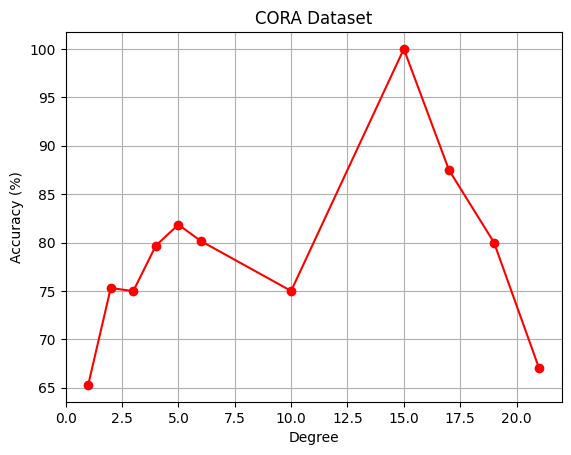

In [89]:
import matplotlib.pyplot as plt

deg = [1, 2, 3, 4, 5, 6, 10, 15, 17, 19, 21]
acc = [65.29, 75.3, 74.98, 79.68, 81.85, 80.15, 75, 100, 87.50, 80, 67]

plt.plot(deg, acc, marker='o', color='red', linestyle='-')
plt.xlabel("Degree")
plt.ylabel("Accuracy (%)")
plt.title("CORA Dataset")
plt.grid(True)
plt.show()


In [43]:
path = '/content/drive/MyDrive/Colab Notebooks/degree19.pth'

In [44]:
best_test_acc = 0.0
for i in range(50):
  loss = train()
  train_acc, val_acc, test_acc = test()

  if test_acc > best_test_acc:
    best_test_acc = test_acc
    torch.save(model.state_dict(), path)
    print(f'Best model saved with accuracy: {best_test_acc:.2f}%')
    print()
  print(f"Epoch: {i:03d}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

Best model saved with accuracy: 0.59%

Epoch: 000, Loss: 1.9525, Train Acc: 0.9856, Val Acc: 0.6060, Test Acc: 0.5916
Best model saved with accuracy: 0.68%

Epoch: 001, Loss: 0.4016, Train Acc: 0.8777, Val Acc: 0.6700, Test Acc: 0.6847
Best model saved with accuracy: 0.77%

Epoch: 002, Loss: 0.3821, Train Acc: 1.0000, Val Acc: 0.7600, Test Acc: 0.7698
Epoch: 003, Loss: 0.0002, Train Acc: 1.0000, Val Acc: 0.5820, Test Acc: 0.5586
Epoch: 004, Loss: 0.0010, Train Acc: 0.9496, Val Acc: 0.3760, Test Acc: 0.3884
Epoch: 005, Loss: 0.0764, Train Acc: 1.0000, Val Acc: 0.4780, Test Acc: 0.4715
Epoch: 006, Loss: 0.0010, Train Acc: 1.0000, Val Acc: 0.5640, Test Acc: 0.5546
Epoch: 007, Loss: 0.0000, Train Acc: 0.9928, Val Acc: 0.5960, Test Acc: 0.5756
Epoch: 008, Loss: 0.0003, Train Acc: 0.9928, Val Acc: 0.6000, Test Acc: 0.5876
Epoch: 009, Loss: 0.0205, Train Acc: 1.0000, Val Acc: 0.6220, Test Acc: 0.6276
Epoch: 010, Loss: 0.0000, Train Acc: 1.0000, Val Acc: 0.6580, Test Acc: 0.6567
Epoch: 011, Lo

In [76]:
model.load_state_dict(torch.load(path))
model.eval()

<ipython-input-76-db444c5f4912>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))


GraphSage(
  (conv1): SAGEConv(1433, 128, aggr=mean)
  (conv2): SAGEConv(128, 7, aggr=mean)
)

In [86]:
# Degree 15
out = model(data.x, data.edge_index)
O = out[mask == False].argmax(dim=1)
count = 0
for i in data.y[mask == False] == O:
  if i == True:
    count+=1
accuracy = count/ len(data.y[mask == False])
print(f'Accuracy on degree 15 nodes: {accuracy:.4f}')

Accuracy on degree 15 nodes: 0.7328


Accuracy on degree 1 nodes: 0.8000


<ipython-input-48-ca3a1ffd2563>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path))
